# Focus stacking with image bunches

Example of focus stacking with automatic alignment and luminosity balance, and partial stacking of image bunches before the final stacking.

In [10]:
from focus_stack import *

In [41]:
def make_job(x, y):
    job = StackJob("job", x + y, input_path="src")
    job.add_action(AlignLayers("align"))
    job.add_action(BalanceLayersLumi("balance", i_min=150, i_max=65385, mask_size=0.8))
    job.add_action(FocusStackBunch("bunches", PyramidStack(), exif_path="src", frames=16, overlap=2, denoise=0))
    job.add_action(FocusStack("stack", PyramidStack(), exif_path="src", postfix='_pyr', denoise=0))
    return job

running align
172 files in folder: 'E:/Focus stacking/2025-02-09 - Alavesia/src'


align:   0%|          | 0/172 [00:00<?, ?it/s]

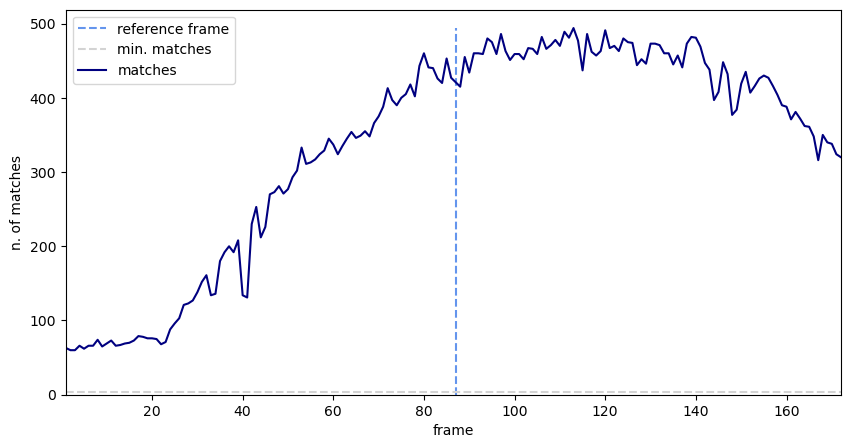

align: elapsed time: 00:28:54.64s                    
align completed                    
running balance
172 files in folder: 'E:/Focus stacking/2025-02-09 - Alavesia/align'


balance:   0%|          | 0/172 [00:00<?, ?it/s]

In [ ]:

for x in ["E:/Focus stacking/2025-02-09 - Alavesia"]:
    for y in ['']:
        make_job(x, y).run()